# Accessing Rendered.ai's Microservices with `anatools`
This notebook will highlight the features of `anatools`, the Rendered.ai SDK, relevant to ML piplines such as updating the data generation configuration and programatically creating a new batch of images. In particular, this notebook presents usage of the anatools utilities that manage the domain adaptation and dataset analytics microservices.

### Contents
- Calculate Dataset Analytics
- Convert Annotations to a Problem Specific Format
- Update a Graph and Submit a Batch of Jobs
- Perform Domain Adaptaion on a Dataset

## Environment
Python 3 is required; 3.7 is preferred.

This notebook depends on the Rendered.ai Python module [anatools](https://pypi.org/project/anatools/). Make sure you install it in your environment.

<code>pip install anatools</code>

Other Required Python Modules
- PyYAML
- json
- wget
- numpy
- matplotlib
- PIL

### Import Python Modules

In [ ]:
import os
import glob
import yaml, json
import wget
import time
from zipfile import ZipFile
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

### Authenticate with Rendered.ai Using the anatools SDK

In [ ]:
import anatools
sdk = anatools.client()
# Log in to the Rendered.ai platform; Register at https://www.rendered.ai/waitlist.html

## Get Information about Available Workspaces and Datasets
All new accounts come with a workspace named 'Example' that is pre-populated with a few datasets. 

First, look at the workspace details and set the AnaClient to use this workspace.

In [ ]:
# Choose a workspace
workspaces = sdk.get_workspaces()
if workspaces is None:
    sdk.login()
    workspaces = sdk.get_workspaces()

workspacesByName={ws['name']:ws for ws in workspaces}
workspaceData = workspacesByName['Example']  ### CHECK THIS - 'Example' is the defualt name for new accounts
sdk.workspace=workspaceData['workspaceId']
print(workspaceData)

Next, get the datasets for the workspace and list them. The status shows if a dataset is currently queued, running, complete, or if the run failed. Completed datasets can get downloaded so the user can view images.

In [ ]:
datasets = sdk.get_datasets()
datasetsByName = {ds['name']:ds for ds in datasets}
print('DATASET NAME \t DESCRIPTION \t STATUS')
print('------------ \t ----------- \t ------')
for n,ds in datasetsByName.items():
    print('{} \t {} \t {}'.format(n, ds['description'], ds['status']))

## Download a Dataset
Downloading an existing dataset allows the user to view images, masks, metadata, and the matching graph associated with the dataset. The `download_dataset` SDK function allows the user to download a zip file.

In [ ]:
# Utility funtion to download datasets
def download_dataset(dataset_id, target_dir):

    if os.path.isdir(target_dir):
        print("\nFound dataset " + target_dir)
    else:
        print("\nThis might take some time...")
        print("Downloading ...")
        datasetZipFile = sdk.download_dataset(dataset_id)
        
        print("Unzipping...")
        os.mkdir(target_dir)
        zf = ZipFile(datasetZipFile)
        zf.extractall(target_dir)

    print("\nDataset Contents of: " + target_dir)
    print(os.listdir(target_dir))

One of the pre-populated datasets in 'Example' workspace, named "ToysinBoxes", has a sample of 50 images based on the default graph of the Rendered.ai example channel.

In [ ]:
datasetName = 'ToysinBoxes'
dataDir = os.path.join('datasets', datasetName)
if not os.path.isdir('datasets'):
    os.mkdir('datasets')

datasets = sdk.get_datasets()
datasetsByName = {ds['name']:ds for ds in datasets}

dataset_metadata = datasetsByName[datasetName]
print(dataset_metadata)

datasetId = datasetsByName[datasetName]['datasetId']

download_dataset(datasetId, dataDir)

### View an Image and an Image Mask
Take a look at an image from the dataset.

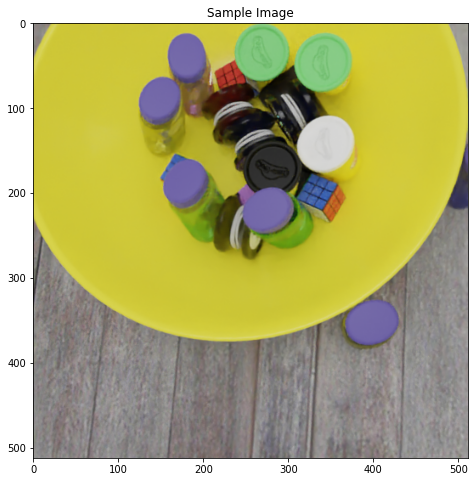

In [23]:
sample_image = Image.open(glob.glob(dataDir+"/images/*.png")[0], 'r')
plt.figure(figsize = (8,8))
plt.title('Sample Image')
plt.imshow(sample_image)
plt.show()

Rendered.ai datasets come with image masks that show how the placement of the objects match the generated images.

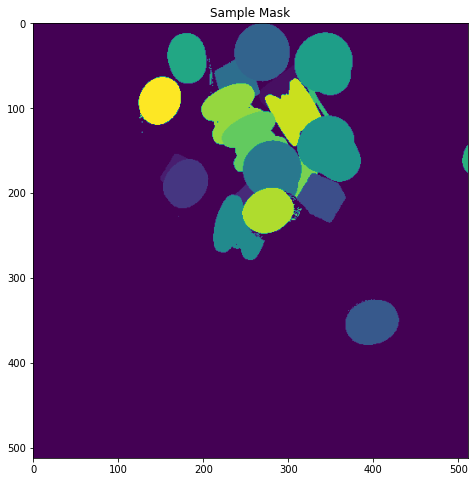

In [22]:
sample_mask_image = Image.open(glob.glob(dataDir+"/masks/*.png")[0], 'r')
plt.figure(figsize=(8, 8))
plt.title('Sample Mask')
plt.imshow(np.asarray(sample_mask_image))
plt.show()

## Calculate Dataset Analytics
The Analytics microservice is used to generate different types of metrics for a dataset. They types of analytics can be retrieved with the `get_analytics_types` SDK function. The basic types of analytics are:

- properties - high level metrics of the job, such as the distribution of image sizes and formats
- objectMetrics - metrics of object classes, such as distributions and bounding box sizes

In [ ]:
sdk.get_analytics_types()

Analtics microservice jobs are kicked off with the command `create_analytics`, which returns an analytics job id.  The analytics job id can be used with `get_analytics` to poll for the job status and collect the results.

In [ ]:
# Create an analytics job : CHOOSE TYPE
#analyticsId = sdk.create_analytics(datasetId, type='properties')
analyticsId = sdk.create_analytics(datasetId, type='objectMetrics')

# Confirm job completion
print("\nThis should just take a couple minutes...")
analytics = sdk.get_analytics(datasetId, analyticsId=analyticsId)
while analytics[0]['status'] not in ['complete', 'failed']:
  time.sleep(10)
  analytics = sdk.get_analytics(datasetId, analyticsId=analyticsId)
  print(analytics[0]['status'])
  
properties = json.loads(analytics[0]['result'])
for key, value in properties.items():
    print(key, ' : ', value)

Display metrics are in image format.

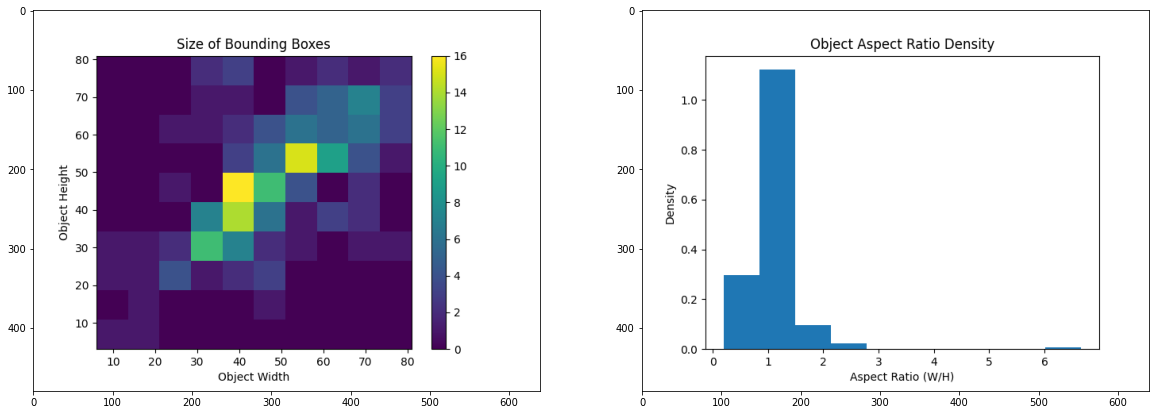

In [21]:
bbox_sizes_image = Image.open("bbox_sizes.png", 'r')
aspect_ratios_image = Image.open("aspect_ratios.png", 'r')

f = plt.figure(figsize=(20, 10))
f.add_subplot(1, 2, 1)
plt.imshow(bbox_sizes_image)

f.add_subplot(1, 2, 2)
plt.imshow(aspect_ratios_image)

plt.show()

## Convert Annotations to a Problem Specific Format
Rendered.ai synthetic datasets can be used with various CV model domains. The `Annotations()` anatools conversion classes are used to convert the default annotations into common formats. The current formats supported are 
- COCO
- PASCAL VOC
- KITTI

In [ ]:
# Download the dataset and the default object mapping files
# Other availailable mappings can be used: https://github.com/Rendered-ai/ana/tree/main/ana/channels/example/mappings
mappingsFileName = 'default.yml'
if os.path.isfile(mappingsFileName):
    print("Found mapping file " + mappingsFileName)
else:
    download_filename = wget.download('https://raw.githubusercontent.com/Rendered-ai/ana/main/ana/channels/example/mappings/default.yml')
    print("Downloaded " + download_filename)

#Create the needed annotaions directory
kittiDir = os.path.join(dataDir, 'kitti_labels')
if not os.path.isdir(kittiDir):
    os.mkdir(kittiDir)

# Create the annotations
anatools.Annotations().dump_kitti(dataDir, kittiDir, mappingsFileName)
print("Created KITTI Labels")

# View some kitti labels
filename = os.listdir(os.path.join(dataDir, 'kitti_labels'))[0]
filepath = os.path.join(dataDir, 'kitti_labels', filename)
print(filepath)
with open(filepath) as fin:
    for i in range(3):
        print(fin.readline())

## Update a Graph and Submit a Batch of Jobs
The graph, a yaml file in the dataset, randomly place 25 toys in a wooden box and renders a 512x512 image. The graph contains the node setup that can be modified to create a new dataset, e.g. the number of objects, an object's color, or type of objects.

Perhaps the object detection performance is not accurately recognizing Rubik's Cubes, and a researcher hypothesizes that detection accruacy will improve by augmenting the training data with a batch of images of only Rubik's Cubes.

This step shows how to make a graph of only Rubik's Cubes.

In [ ]:
with open(os.path.join(dataDir, 'graph.yaml'), 'r') as gf:
    graphData = yaml.safe_load(gf)
graph = graphData['graph']

randomPlacementNodeName, randomPlacementNodeData = [(k,v) for k,v in graph['nodes'].items() if v['nodeClass']=='Random Placement'][0]
print('Original Object Links: {}'.format(randomPlacementNodeData['links']))

new_object_generator_links = [l for l in randomPlacementNodeData['links']['Object Generators'] if "Rubik's Cube" in l['sourceNode']]
randomPlacementNodeData['links']['Object Generators'] = new_object_generator_links
print('\nUpdated Object Links: {}'.format(randomPlacementNodeData['links']))

with open(os.path.join(dataDir, 'cube_graph.yaml'), 'w') as gf:
    _ = yaml.dump(graph, gf)

Rendered.ai graphs are channel specific. In this step, the channelId is retrieved, the modified graph i staged, and a batch of jobs are kicked off.

In [ ]:
channelId = [k for k, v in sdk.channels.items() if v == 'example'][0]
graphId = sdk.create_staged_graph(name="Rubik's Cubes", channelId=channelId, graph=graph, description='Only one object type')
print("Graph Uploaded")
n_runs = 5
just_cubes_dataset_id = sdk.create_dataset(
    "Only Rubik's Cubes", graphId, description="{} Runs - Only Rubik's Cubes".format(n_runs), runs=n_runs, priority=1)
print("\nJob Started")

### Monitor and download this new dataset once job is finished
Monitoring a dataset is easy with the get_datasets API call. Once a dataset has been created, a job will start and it can be monitored in this way. The user can check the status of the job.

In [ ]:
datasetData = sdk.get_datasets(datasetId=just_cubes_dataset_id)[0]
print("\nThis might take some time...")
while datasetData['status'] != 'complete':
    time.sleep(10)
    datasetData = sdk.get_datasets(datasetId=just_cubes_dataset_id)[0]
    print(datasetData['status'])

## Perform Domain Adaptaion on a Dataset
The CycleGAN models can be retrieved with `get_gan_models`.  The following use shows creating a new dataset by inferencing an existing dataset with a CycleGAN domain adaptation model.

---
**NOTE**

The Rendered.ai Domain Adaptation Microservice is not available to all plans.

[Upgrade in your organization settings.](https://deckard.rendered.ai/organizations?menu=billing)

---

In [ ]:
models = sdk.get_gan_models()
try:
  modelData = [m for m in models if m['name']=='Airborne Roof'][0]
except IndexError:
  raise UserWarning('No models available')

# Start the job
ganStatusId = sdk.create_gan_dataset(modelData['modelId'], just_cubes_dataset_id)

# Confirm job completion
gan_info = sdk.get_gan_dataset(ganStatusId)
while gan_info['status'] != 'complete':
  time.sleep(10)
  gan_info = sdk.get_gan_dataset(ganStatusId)
  print(gan_info['status'])
print(gan_info)